# MyDatasetの定義

In [21]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional
from PIL import Image
import multiprocessing as mp


class PreTrainDataset_old(Dataset):
    def __init__(self,
                 test_doc_id_list,
                 test_mode=False,
                 # input_path='../kuzushiji_recognition/synthetic_images/input_images/',
                 input_path='../kuzushiji_recognition/synthetic_images/tmp_entire_data/',
                 json_path='../kuzushiji_recognition/synthetic_images/gt_json.json',
                 transform=None,
                 target_width=300):  # デフォルトの横幅を300に設定
        super().__init__()
        self.test_doc_id_list = test_doc_id_list
        self.input_path = input_path
        self.transform = transform
        self.target_width = target_width
        
        # 画像のIDをリストにして保管。
        self.input_imageID_list = []
        for file_name in os.listdir(self.input_path):
            file_path = os.path.join(self.input_path, file_name)
            if os.path.isfile(file_path):
                # test_modeに応じて、テスト用データと学習用データを切り分ける
                # XOR (^) を利用:
                # - test_mode=False (学習時): doc_idがtest_listにない(False) -> 全体はFalse -> 読み込む
                # - test_mode=True (テスト時): doc_idがtest_listにある(True) -> 全体はFalse -> 読み込む
                if not (file_name.split('_sep_')[0] in self.test_doc_id_list) ^ test_mode:
                    self.input_imageID_list.append(file_name.split('.')[0])
        
        # アノテーションデータを保持するjsonファイルをロード
        self.gt_json = self.load_GT_json(json_path)

        # 入力画像に対応するアノテーションデータが存在するか確認。(コメントアウト)
        # for i in range(len(self.input_imageID_list)-1, -1,-1):
        #     if not self.input_imageID_list[i] in self.gt_json:
        #         del self.input_imageID_list[i]

    def __len__(self):
        return len(self.input_imageID_list)

    def __getitem__(self, index):
        image_id = self.input_imageID_list[index]
        image = Image.open(self.input_path + image_id + '.jpg')
        
        # 1. 元の画像のサイズを取得
        original_w, original_h = image.size
        
        # 2. アスペクト比を保持したまま、横幅を指定サイズにリサイズ
        aspect_ratio = original_h / original_w
        new_w = self.target_width
        new_h = int(self.target_width * aspect_ratio)
        new_size = (new_h, new_w)  # functional.resizeはH,Wの順で指定
        
        # 3. 画像をリサイズ
        image = functional.resize(image, new_size, interpolation=functional.InterpolationMode.BILINEAR)
        
        # 4. リサイズ後のサイズで正解マップを生成
        tensor_gt = self.return_tensor_gt(
            gt_info_dic=self.gt_json['files'][image_id],
            image=image,
            original_size=(original_w, original_h)
        )

        if self.transform:
            image = self.transform(image)
            
        return image, tensor_gt

    def load_GT_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print("json データを読み込みました。")
        return data

    def return_ground_truth_canvas(self, image):
        w, h = image.size
        main_region = np.zeros((h, w), dtype=np.float64)
        main_affinity = np.zeros((h, w), dtype=np.float64)
        furi_region = np.zeros((h, w), dtype=np.float64)
        furi_affinity = np.zeros((h, w), dtype=np.float64)
        return main_region, main_affinity, furi_region, furi_affinity

    def add_perspective_gaussian_to_canvas(self, canvas, points, amplitude=1.0):
        # 領域の4点を取得
        src_points = np.array(points, dtype=np.float32)

        # ガウス分布を生成するための仮想的な正方形領域を定義
        width = int(max(np.linalg.norm(src_points[0] - src_points[1]), np.linalg.norm(src_points[2] - src_points[3])))
        height = int(max(np.linalg.norm(src_points[0] - src_points[3]), np.linalg.norm(src_points[1] - src_points[2])))
        
        # 最小サイズを保証（1ピクセル未満にならないようにする）
        width = max(width, 1)
        height = max(height, 1)
        
        # ガウス分布のサイズを調整（小さすぎる場合は大きくする）
        min_gaussian_size = 5
        if width < min_gaussian_size or height < min_gaussian_size:
            scale = max(min_gaussian_size / width, min_gaussian_size / height)
            width = max(int(width * scale), min_gaussian_size)
            height = max(int(height * scale), min_gaussian_size)
        
        dst_points = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

        # ガウス分布を生成
        x = np.linspace(-width / 2, width / 2, width)
        y = np.linspace(-height / 2, height / 2, height)
        x, y = np.meshgrid(x, y)
        
        # シグマ値の調整（小さすぎる場合は最小値を設定）
        min_sigma = 1.0
        sigma_x = max(width / 5.0, min_sigma)
        sigma_y = max(height / 5.0, min_sigma)
        
        gaussian = amplitude * np.exp(-((x**2) / (2 * sigma_x**2) + (y**2) / (2 * sigma_y**2)))

        try:
            # Perspective Transformation行列を計算
            matrix = cv2.getPerspectiveTransform(dst_points, src_points)

            # 入力ガウシアンを適切な形式に変換
            gaussian = gaussian.astype(np.float32)  # float32型に変換
            
            # ガウス分布をPerspective Transformationで変形
            transformed_gaussian = cv2.warpPerspective(
                gaussian,
                matrix,
                (canvas.shape[1], canvas.shape[0]),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )

            # キャンバスにガウス分布を追加
            canvas += transformed_gaussian

        except Exception as e:
            print(f"Warning: perspective transformation failed - {e}")
            # エラーが発生した場合は、キャンバスをそのまま返す

        return canvas

    def design_gaussian_map(self, canvas, point_list):
        for points in point_list:
            p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y = points
            self.add_perspective_gaussian_to_canvas(canvas, ((p1x, p1y), (p2x, p2y), (p3x, p3y), (p4x, p4y)), amplitude=1.0)
        return canvas

    def return_tensor_gt(self, gt_info_dic, image, original_size=None):
        """
        正解マップを生成する
        Args:
            gt_info_dic: アノテーションデータ
            image: リサイズ済みの画像
            original_size: 元の画像サイズ（width, height）
        """
        main_region, main_affinity, furi_region, furi_affinity = self.return_ground_truth_canvas(image)

        # スケーリング係数を計算
        if original_size:
            orig_w, orig_h = original_size
            current_w, current_h = image.size
            scale_w = current_w / orig_w
            scale_h = current_h / orig_h
        else:
            scale_w = scale_h = 1.0

        # キャンバスマップを作成
        canvas_list = []
        canvas_map = {
            'main_region': main_region,
            'main_affinity': main_affinity,
            'furi_region': furi_region,
            'furi_affinity': furi_affinity
        }
        
        for name, canvas in canvas_map.items():
            if name in gt_info_dic:
                # 座標をスケーリング
                scaled_points = []
                for points in gt_info_dic[name]:
                    scaled_point = []
                    for i, coord in enumerate(points):
                        # 偶数インデックスはx座標、奇数インデックスはy座標
                        scaled_coord = coord * (scale_w if i % 2 == 0 else scale_h)
                        scaled_point.append(scaled_coord)
                    scaled_points.append(scaled_point)
                
                canvas_list.append(self.design_gaussian_map(canvas, scaled_points))

        # それぞれをtorch tensorに変換
        tensor_list = []
        for canvas in canvas_list:
            tensor_list.append(torch.from_numpy(canvas.astype(np.float32)).clone())
        
        return_tensor = torch.stack(tensor_list)
        return return_tensor

    def create_optimized_dataloader_for_old_dataset(dataset, batch_size=8, num_workers=4):
        """
        PreTrainDataset_old用の最適化されたDataLoaderを作成
        
        Args:
            dataset: PreTrainDataset_oldのインスタンス
            batch_size (int): バッチサイズ
            num_workers (int): データローディングに使用するワーカープロセスの数
        
        Returns:
            DataLoader: 最適化されたDataLoader
        """
        from torch.utils.data import DataLoader
        
        # メモリ効率のための設定
        persistent_workers = num_workers > 0
        prefetch_factor = 2 if persistent_workers else None
        
        # DataLoaderの作成
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
            # メモリ効率のための追加設定
            drop_last=False,  # データセットの最後のバッチも使用
            generator=torch.Generator(),  # 再現性のための乱数生成器
        )

# MyDatasetオブジェクト作成

In [22]:

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = PreTrainDataset_old(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    transform=transform,
    target_width=300  # 横幅を300ピクセルに固定
)

json データを読み込みました。


# 正解データの表示と時間計測<br>
デフォルトは1秒前後（一枚目：0.73s）


Sample 0:
Time taken: 0.80 seconds
Memory change: 0.66 MB
Output tensor shapes:
Input image: torch.Size([3, 471, 300])
GT channel 0: torch.Size([471, 300])


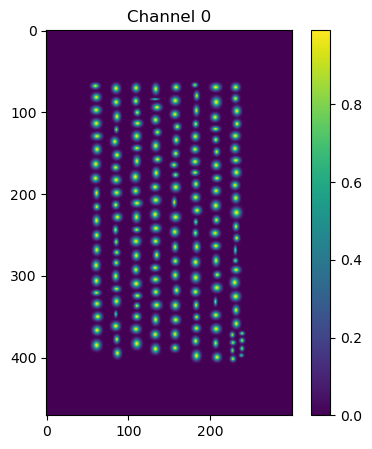

GT channel 1: torch.Size([471, 300])


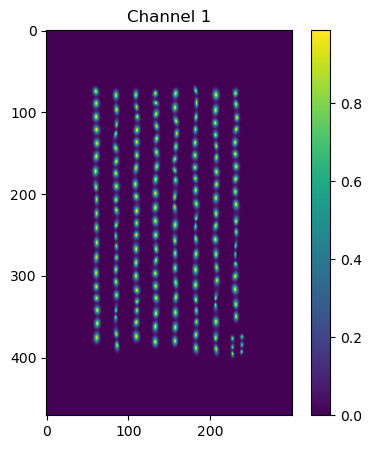

GT channel 2: torch.Size([471, 300])


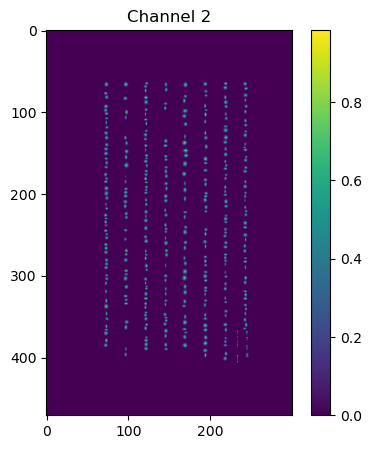

GT channel 3: torch.Size([471, 300])


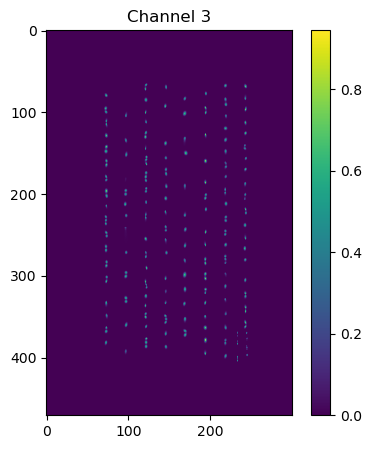


Sample 1:
Time taken: 0.60 seconds
Memory change: 0.65 MB
Output tensor shapes:
Input image: torch.Size([3, 470, 300])
GT channel 0: torch.Size([470, 300])


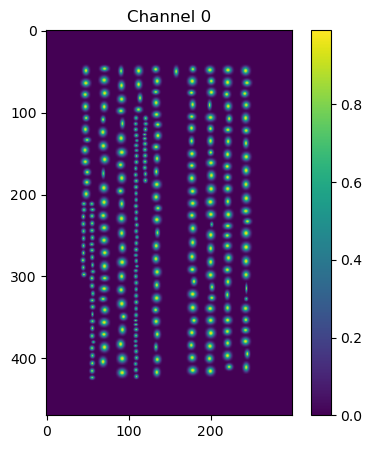

GT channel 1: torch.Size([470, 300])


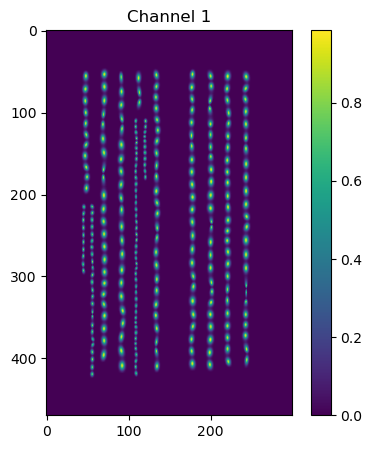

GT channel 2: torch.Size([470, 300])


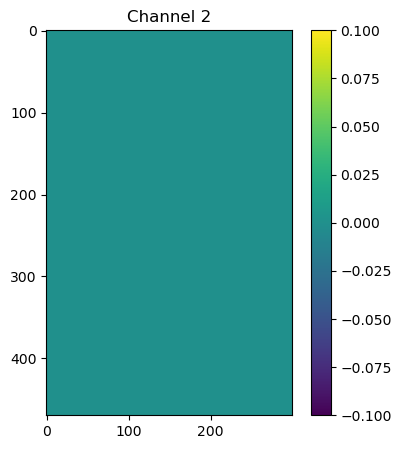

GT channel 3: torch.Size([470, 300])


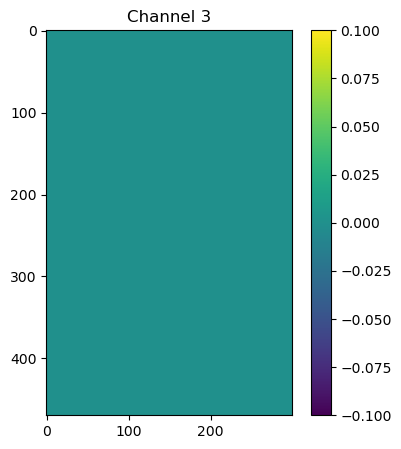

KeyboardInterrupt: 

In [26]:
import time
import psutil
import os

process = psutil.Process()

for i in range(10):
    start_time = time.time()
    start_memory = process.memory_info().rss / 1024 / 1024  # MB単位

    first_data = dataset[i]
    
    end_time = time.time()
    end_memory = process.memory_info().rss / 1024 / 1024
    
    print(f"\nSample {i}:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Memory change: {end_memory - start_memory:.2f} MB")
    print(f"Output tensor shapes:")
    print(f"Input image: {first_data[0].shape}")
    for j in range(4):
        print(f"GT channel {j}: {first_data[1][j].shape}")
        plt.figure(figsize=(5, 5))
        plt.imshow(first_data[1][j])
        plt.title(f"Channel {j}")
        plt.colorbar()
        plt.show()